In [88]:
import os
import glob
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import sqrt
import studio2021

In [89]:
def print_coefficients(model, features):
    """
    this function takes in a model column and a features column
    and prints the coefficient along with its feature name.
    """
    feats = list(zip(features, model.coef_))
    print(*feats, sep="\n")

In [90]:
path = os.path.abspath('')
filename = ('1k_results.csv')
filepath = os.path.join(path, "results", filename)
print(filepath)
dadus = pd.read_csv(filepath)

# selects % of the data
# dadus = dadus.sample(frac=0.1, random_state=0)

print(f'number of data points: {len(dadus)}')
dadus.head()
dadus.columns

/Users/preston/Documents/GitHub/msdc-thesis/tool/results/1k_results.csv
number of data points: 999


Index(['filename', 'site', 'size', 'footprint', 'height', 'num_stories',
       'num_adiabatic', 'inf_rate', 'orientation', 'WWR', 'frame', 'polyiso_t',
       'cellulose_t', 'setback', 'rear_setback', 'side_setback',
       'structure_setback', 'assembly_r', 'area_buildable', 'surf_area',
       'volume', 'EUI', 'carbon', 'kgCO2e'],
      dtype='object')

In [91]:
# all of the features of interest
selected_inputs = [
    'site',
    'size',
    'footprint',
    'height',
    'num_stories',
    'num_adiabatic',
    'inf_rate',
    'orientation',
    'WWR',
    'frame',
    'polyiso_t',
    'cellulose_t',
    'setback',
    'rear_setback',
    'side_setback',
    'structure_setback',
    'assembly_r',
    'area_buildable',
    'surf_area',
    'volume'
]

# compute the square and sqrt of each feature
all_features = []
for data_input in selected_inputs:
    square_feat = data_input + '_square'
    sqrt_feat = data_input + '_sqrt'

    # compute the square and square root as two new features
    dadus[square_feat] = dadus[data_input]**2
    dadus[sqrt_feat] = np.sqrt(dadus[data_input])
    all_features.extend([data_input, square_feat, sqrt_feat])

# split the data into features and energy
energy = dadus['EUI']
dadus = dadus[all_features]

dadus.head()


,site,site_square,site_sqrt,size,size_square,size_sqrt,footprint,footprint_square,footprint_sqrt,height,...,assembly_r_sqrt,area_buildable,area_buildable_square,area_buildable_sqrt,surf_area,surf_area_square,surf_area_sqrt,volume,volume_square,volume_sqrt
0,3,9,1.732051,200,40000,14.142136,200,40000,14.142136,10,...,2.711279,2225.954944,4.954875e+06,47.180027,967.188914,935454.394784,31.099661,2000,4000000,44.72136
1,3,9,1.732051,200,40000,14.142136,200,40000,14.142136,10,...,2.711279,2225.954944,4.954875e+06,47.180027,967.188914,935454.394784,31.099661,2000,4000000,44.72136
2,3,9,1.732051,200,40000,14.142136,200,40000,14.142136,10,...,2.711279,1972.217303,3.889641e+06,44.409653,970.726696,942310.318327,31.156487,2000,4000000,44.72136
3,3,9,1.732051,200,40000,14.142136,200,40000,14.142136,10,...,2.711279,1972.217303,3.889641e+06,44.409653,970.726696,942310.318327,31.156487,2000,4000000,44.72136
4,0,0,0.000000,200,40000,14.142136,200,40000,14.142136,10,...,2.711279,810.158325,6.563565e+05,28.463280,965.841871,932850.519777,31.077997,2000,4000000,44.72136


In [92]:
# split data
train_and_validation_dadus, test_dadus, train_and_validation_energy, test_energy = \
    train_test_split(dadus, energy, test_size=.20, random_state=6)
train_dadus, validation_dadus, train_energy, validation_energy = \
    train_test_split(train_and_validation_dadus,
                     train_and_validation_energy, test_size=.125, random_state=6)

# standardization
train_scaler = StandardScaler().fit(train_dadus)

train_dadus = train_scaler.transform(train_dadus)
validation_dadus = train_scaler.transform(validation_dadus)
test_dadus = train_scaler.transform(test_dadus)

In [93]:
# Linear Regression
linear_model = LinearRegression().fit(train_dadus, train_energy)
predict_energy = linear_model.predict(test_dadus)
test_rmse = sqrt(mse(predict_energy, test_energy))

# Ridge Regression
l2_penalty = np.logspace(-5, 5, 11, base=10)
data = []
for l2 in l2_penalty:
    ridge_model = Ridge(l2, random_state=0).fit(train_dadus, train_energy)
    train_predict_energy = ridge_model.predict(train_dadus)
    train_rmse = sqrt(mse(train_predict_energy, train_energy))
    validation_predict_energy = ridge_model.predict(validation_dadus)
    validation_rmse = sqrt(mse(validation_predict_energy, validation_energy))
    data.append({
        'l2_penalty': l2,
        'model': ridge_model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse
    })
ridge_data = pd.DataFrame(data)


      l2_penalty                                  model  train_rmse  \
0        0.00001     Ridge(alpha=1e-05, random_state=0)    1.286275   
1        0.00010    Ridge(alpha=0.0001, random_state=0)    1.286494   
2        0.00100     Ridge(alpha=0.001, random_state=0)    1.286544   
3        0.01000      Ridge(alpha=0.01, random_state=0)    1.286892   
4        0.10000       Ridge(alpha=0.1, random_state=0)    1.299763   
5        1.00000                  Ridge(random_state=0)    1.345937   
6       10.00000      Ridge(alpha=10.0, random_state=0)    1.390017   
7      100.00000     Ridge(alpha=100.0, random_state=0)    1.828770   
8     1000.00000    Ridge(alpha=1000.0, random_state=0)    3.890044   
9    10000.00000   Ridge(alpha=10000.0, random_state=0)   10.612253   
10  100000.00000  Ridge(alpha=100000.0, random_state=0)   18.435174   

    validation_rmse  
0          1.347063  
1          1.348180  
2          1.348597  
3          1.351043  
4          1.375605  
5          1.44

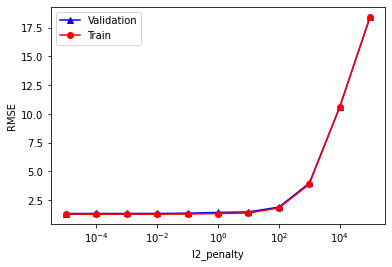

In [94]:
# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['validation_rmse'],
         'b-^', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l2_penalty')
plt.ylabel('RMSE')
plt.legend()

print(ridge_data)

In [95]:
index = ridge_data['validation_rmse'].idxmin()
best_row = ridge_data.loc[index]
best_l2 = best_row['validation_rmse']

ridge_predict = best_row['model'].predict(test_dadus)
test_rmse = sqrt(mse(ridge_predict, test_energy))
print(test_rmse)

print_coefficients(best_row['model'], all_features)
num_zero_coeffs_ridge = 0

1.4051777768218603
('site', -2.9275736078521013)
('site_square', 2.7478457051661236)
('site_sqrt', -0.6750023703815439)
('size', -5.741618188738493)
('size_square', -5.741607428460331)
('size_sqrt', -5.741619158076425)
('footprint', -5.741618544356928)
('footprint_square', -5.74161916351598)
('footprint_sqrt', -5.741610151290252)
('height', -5.741606699652975)
('height_square', -5.741617220771773)
('height_sqrt', -5.741610205380371)
('num_stories', -5.741618979758569)
('num_stories_square', -5.74160783100315)
('num_stories_sqrt', -5.7416052226149095)
('num_adiabatic', -5.741621340200238)
('num_adiabatic_square', -5.741609747084409)
('num_adiabatic_sqrt', -5.741607994451248)
('inf_rate', 0.010980968236952614)
('inf_rate_square', 0.010980514984076624)
('inf_rate_sqrt', 0.010980529043752598)
('orientation', 0.0)
('orientation_square', 0.0)
('orientation_sqrt', 0.0)
('WWR', 27.615411616351263)
('WWR_square', -7.128805248280038)
('WWR_sqrt', -12.941821766007639)
('frame', -0.388868542525584

/Users/preston/opt/miniconda3/envs/research/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.984e+02, tolerance: 2.969e+01
  model = cd_fast.enet_coordinate_descent(
/Users/preston/opt/miniconda3/envs/research/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.818e+02, tolerance: 2.969e+01
  model = cd_fast.enet_coordinate_descent(
/Users/preston/opt/miniconda3/envs/research/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

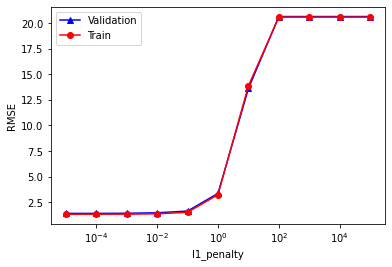

In [96]:
# LASSO
l1_penalty = np.logspace(-5, 5, 11, base=10)
data = []
for l1 in l1_penalty:
    lasso_model = Lasso(l1, random_state=0).fit(train_dadus, train_energy)
    train_predict_energy = lasso_model.predict(train_dadus)
    train_rmse = sqrt(mse(train_predict_energy, train_energy))
    validation_predict_energy = lasso_model.predict(validation_dadus)
    validation_rmse = sqrt(mse(validation_predict_energy, validation_energy))
    data.append({
        'l1_penalty': l1,
        'model': lasso_model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse
    })
lasso_data = pd.DataFrame(data)

plt.plot(lasso_data['l1_penalty'], lasso_data['validation_rmse'],
         'b-^', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty')
plt.ylabel('RMSE')
plt.legend()

In [97]:
# Coefficient Inspection
index = lasso_data['validation_rmse'].idxmin()
best_row = lasso_data.loc[index]
best_l1 = best_row['validation_rmse']

lasso_predict = best_row['model'].predict(test_dadus)
test_rmse = sqrt(mse(lasso_predict, test_energy))
print(test_rmse)

print_coefficients(best_row['model'], all_features)
num_zero_coeffs_lasso = 28

for feature, coef in zip(all_features, best_row['model'].coef_):
    if abs(coef) <= 10 ** -17:
        print(feature)

1.443776118263765
('site', 1.0797070057879974)
('site_square', -3.0017985184835174)
('site_sqrt', 2.267293267174918)
('size', -18.232000284287246)
('size_square', -3.3769103331373705e-12)
('size_sqrt', -0.0)
('footprint', -0.0)
('footprint_square', -0.0)
('footprint_sqrt', -0.0)
('height', -0.0)
('height_square', -0.0)
('height_sqrt', -0.0)
('num_stories', -0.0)
('num_stories_square', -0.0)
('num_stories_sqrt', -0.0)
('num_adiabatic', -0.0)
('num_adiabatic_square', -0.0)
('num_adiabatic_sqrt', -0.0)
('inf_rate', 0.03479973347696026)
('inf_rate_square', 2.1038795804854617e-17)
('inf_rate_sqrt', 2.1038795804854617e-17)
('orientation', 0.0)
('orientation_square', 0.0)
('orientation_sqrt', 0.0)
('WWR', 14.105511342009466)
('WWR_square', -2.180095803828153)
('WWR_sqrt', -4.202580170270023)
('frame', -0.9525359254426704)
('frame_square', 0.07080388266514816)
('frame_sqrt', -1.336427683977271)
('polyiso_t', -0.6176409000974054)
('polyiso_t_square', -1.73857014462883e-17)
('polyiso_t_sqrt', -1

In [99]:
best_row

l1_penalty                                    0.00001
model              Lasso(alpha=1e-05, random_state=0)
train_rmse                                   1.310513
validation_rmse                              1.389474
Name: 0, dtype: object